### Juan David Orjuela - María Sofía Álvarez López

<h1 align='center'>Laboratorio 2: Machine Learning Techniques</h1>

## Problema 
Una de las ventajas que ha brindado la tecnología y la globalización es poder encontrar diferentes referencias de diferentes productos, en especial si son productos de e-commerce, eventos de entretenimiento o reserva de hoteles y parques. En este último, una de las plataformas con mayor interacción a la hora de calificar hoteles es TripAdvisor, ya que permite establecer comentarios sobre hoteles y otorgarles una calificación. 

Ante esta oportunidad de crecimiento turpistica, dada la reactivación económica, han decidido establecer un hotel para poder brindar atención a sus clientes. Y dado que su hotel es bastante nuevo, aún no tienen registros en las grandes plataformas de calificación hotelera, pero si tienen ya varios comentarios en Redes Sociales y quisieran entender cual sería esa posible calificación que tendrían. Para ellos, los expertos en el mercado hotelero le han brindado la información de las reseñas de 2016 de TripAdvisor junto a sus calificaciones.<br>

Ellos han realizado una pre-exploración de los datos, y se han dado cuenta que las calificaciones se encuentran desbalanceadas. Por lo que le han recomendado utilizar una **SVM** para poder combatir este problema, dado que les interesaría con gran importancia saber si la calificación del hotel es muy baja.

También, alguno de sus compañeros Analistas de Datos, al ver que el problema es de textos. Le recomendó utilizar un **modelo estadístico**, con el fin de establecer una primera aproximación que les pueda ayudar a entender mejor el problema.

Y por último, dada su investigación que ha realizado sobre técnicas de Aprendizaje de Datos, ha establecido que las **Redes Neuronales Artificiales** pueden brindar un buen modelo que ayude a generalizar este análisis de sentimientos.

In [41]:
# ESAI
import inflect
import numpy as np
import contractions
import pandas as pd
from sklearn.svm import SVC
from joblib import dump, load
import re, string, unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from nltk import word_tokenize, sent_tokenize
from sklearn import feature_extraction, feature_selection
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve, make_scorer, f1_score

## 1. Entendimiento del problema
Lo primero que hacemos es cargar las librerías y el conjunto de datos, con el fin de entender a qué nos estamos enfrentando.

In [5]:
reviews = pd.read_csv('reviews.csv', delimiter=',')

Con esto, podemos ver una muestra de los datos. Aquí, nos damos cuenta que nuestro conjunto de datos consiste de dos columnas: "Review", con las reseñas de los clientes (escritas en inglés), y "Rating", con la puntuación dada por el cliente de acuerdo con su visita al hotel. Asimismo, vemos que tenemos 20491 reseñas.

In [6]:
print("Tamaño del conjunto de datos:", len(reviews))
reviews.sample(5)

Tamaño del conjunto de datos: 20491


,Review,Rating
9877,nice booked venere really pleasant hotel 5 min...,4
11386,loved manny santiago family stayed twice las c...,5
2594,poor service stayed new year paid highly infla...,2
17339,best buy hong kong trip hong kong cosmopolitan...,5
10780,gem hotel fabulous location just returned pari...,5


Asimismo, vemos que las calificaciones están dadas en un rango de 1-5. A priori, leyendo algunas de las reseñas y de acuerdo con las reglas del negocio, sabemos que una puntuación de 1 es muy mala y, una de 5, excelente.

In [7]:
reviews['Rating'].unique()

array([4, 2, 3, 5, 1])

Ahora, queremos ver si nuestro conjunto de datos tiene entradas nulas. Para ello, revisamos si hay reseñas que correspondan con la cadena vacía "" o con un sólo espacio " ". Note que no hay ninguna que satisfaga estas condiciones, pues obtenemos un <i>dataframe</i> vacío, como vemos en la celda a continuación. Podemos hacer también una revisión con el método <code>isna()</code> de <code>pandas</code>. Este indica si hay algún valor de los datos que tenga como valor <code>None</code> o <code>numpy.NaN</code>. Vemos entonces que nuestro conjunto de datos no tiene ni nulos, ni faltantes.

In [8]:
print(reviews.isna().sum())
reviews[(reviews['Review'] == "") | (reviews['Review'] == " ")]

Review    0
Rating    0
dtype: int64


,Review,Rating


Nos damos cuenta ahora de que sólo tenemos una variabe (la reseña) y que la variable objetivo (target) es la puntuación dada por el usuario. Asimismo, partimos el conjunto de datos entre los datos de entrenamiento y de test: esto es crucial, pues, tras entrenar el modelo, debemos validarlo con datos que este nunca había visto. De acuerdo con el libro de Gerón <a href='#geron'>[1]</a>, una buena división entre datos de entrenamiento y test es 80% y 20%, respectivamente. Esta es la división que usaremos para este modelo.

In [9]:
X, Y = reviews['Review'], reviews['Rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.2, random_state=48)

Con esto, procedemos a hacer todo el entrenamiento sobre el conjunto de $X_{\mathrm{train}},Y_{\mathrm{train}}$ y guardamos el test en la "caja fuerte" hasta que sea el momento de la validación.

Queremos ver la distribución de las clases de nuestro conjunto de datos. Para ello, consideremos el siguiente histograma.

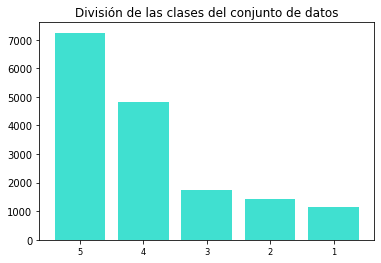

In [10]:
val_counts_y = Y_train.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='turquoise')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

Podemos ver claramente que, como sugiere el enunciado, las clases están desbalanceadas. Primero que todo, de acuerdo con el enunciado del problema, esto resulta en un inconveniente puesto que nos interesan las reseñas muy bajas (podríamos considerar estas como las clases 1 y 2, incluso la 3), pero estas son las clases con menos (es decir, son las clases minoritarias). Por lo tanto, debemos utilizar técnicas de balanceo de clases. Podemos abordar este problema desde el preprocesamiento, usando técnicas de oversampling como SMOTE, o en la implementación del algoritmo, diciéndole que estamos trabajando con clases desbalanceadas. Quisiéramos ver ambos comportamientos, entonces intentaremos explorar ambas alternativas. Esto se realiza más adelante, en las secciones de preprocesamiento y modelado (respectivamente) de este documento.

---
Como parte final de este entendimiento de los datos, queremos ver (a priori) cuáles son las palabras más utilizadas en el conjunto de datos. Para ello, usamos la librería <code>WordCloud</code>.

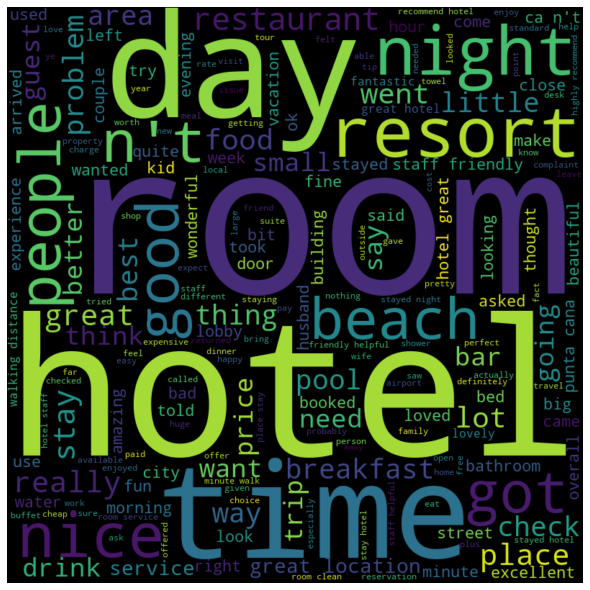

In [19]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,min_font_size = 10).generate(" ".join(data.values))                       
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
    return wordcloud

wc = wordCloud_generator(X_train)
wc

Con esta nube de palabras, podemos confirmar que nuestra base de datos corresponde a reseñas de hoteles. Note que las palabras "nice", "good", "great" y "friendly", entre otras, resaltan. Esto indica que, en efecto, hay varias críticas positivas (confirmando el desbalance en los datos).

## 2. Preprocesamiento

### 2.1 Eliminación de palabras no informativas
Antes de hacer cualquier preprocesamiento de los datos asociado a la tokenización y eliminación de palabras no informativas, nos dimos cuenta de que, en la nube de palabras, obtuvimos que una de las "palabras" más comunes es "n't". Sabemos que, en inglés, esta es la contracción de la negación para expresiones como: can't, don't, doesn't, didn't y couldn't, entre otras. Explorando más a fondo el conjunto de datos, nos dimos cuenta de que había una separación extraña entre estas palabras. Por ejemplo, "can't" estaba escrito como "ca n't". Esto es un problema pues, al realizar el preprocesamiento posterior, si tokenizamos, por ejemplo, por palabras, se separaría en dos tokens diferentes (y ca no tiene sentido por sí sola). 

Investigando un poco, encontramos que las contracciones que finalizan en n't en inglés son las que se encuentran en el diccionario a continuación.

In [12]:
our_contractions = { 
"ai n't": "am not",
"are n't": "are not",
"ca n't": "cannot",
"could n't": "could not",
"did n't": "did not",
"does n't": "does not",
"do n't": "do not",
"had n't": "had not",
"has n't": "has not",
"have n't": "have not",
"is n't": "is not",
"may n't": "may not",
"might n't": "might not",
"must n't": "must not",
"need n't": "need not",
"ought n't": "ought not",
"sha n't": "shall not",
"sha' n't": "shall not",
"should n't": "should not",
"was n't": "was not",
"were n't": "were not",
"wo n't": "will not",
"would n't": "would not",
}

def change_contractions(series, our_contractions):
    return series.replace(our_contractions, regex=True)

Asimismo, leyendo algunas de las reseñas, nos dimos cuenta que había algunos caracteres no ASCII. Por ejemplo, nos dimos cuenta de que, en una reseña, en vez de decir "piñas coladas" decía "piëÙ_a coladas". Otros ejemplos extraños que encontramos (seguramente por errores en las tildes o apóstrofes usados) son: wasn_Çé_, cafÄ au lait, o_Çéælock. Para esto, definimos una función que quite los caracteres no ASCII para las palabras (tokens) de cada documento del corpus.

In [13]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

Asimismo, es importante que todas las palabras tengan una capitalización homogénea (en este caso, queremos que estén en minúscula). 

In [14]:
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

Por otro lado, nos dimos cuenta de que la puntuación no provee información adicional en el contexto. Si no se elimina, puede aumentar la dimensionalidad de los datos. Por ejemplo, no tiene sentido tener "almuerzo!" y "almuerzo" como palabras diferentes. Para ello, removemos toda la puntuación usando expresiones regulares.

In [15]:
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Ahora, consideramos que los números no proveen información relevante. Por ejemplo, hay precios que no se repetirán con frecuencia entre los documentos, porque pueden referirse a productos diferentes o a visitas en años diferentes (y los precios cambian entre años, por factores como la inflación). Por ejemplo, si una reseña dice algo como: "Eso estaba muy costoso, su precio era de 18.50", es suficiente con quedarnos con el hecho de que era muy costoso. Asimismo, consideramos que palabras que incluyan números (por ejemplo "250/night" son irrelevantes para el problema pues la frecuencia de repetición será muy baja. Podemos, entonces, eliminarlas.

In [16]:
def remove_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        new_word = re.sub('\d+.*', '', word)
        if not word.isnumeric() and new_word != '':
            new_words.append(word)
    return new_words

Por un argumento similar, podemos eliminar las fechas de estadía que algunos clientes hayan podido incluir en sus reseñas. Esto es información irrelevante para el análisis de sentimientos. 

In [17]:
def remove_dates(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+/\d+/\d+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Como última etapa del preprocesamiento, eliminamos las palabras que no contribuyen al contexto. Para ello, usamos dos listas. Primero, usamos las "stop words" características del inglés, usando el módulo <code>stopwords</code> de la librería <code>nltk</code>. 

La otra lista corresponde a las palabras de mayor frecuencia entre los documentos del corpus que consideramos no aportan significativamente al análisis de sentimientos. Veamos las 10 primeras palabras que obtuvimos de la nube de palabras que hicimos en el preprocesamiento.

In [20]:
print(list(wc.words_.keys())[:10])
our_stopwords = list(wc.words_.keys())[:6] + ['rooms']

['room', 'hotel', 'day', 'time', 'resort', 'night', 'nice', 'good', "n't", 'people']


Vemos que las 6 primeras palabras son demasiado generales y aplican a cualquier tipo de reseña sin emitir un juicio de valor que nos permita relacionarlo con el puntaje asignado por el usuario. No obstante, "nice" y "good" sí informan sobre la experiencia. Podemos catalogar como "stop-words" a las 6 primeras palabras de esta lista y eliminarlas de nuestro conjunto de datos.

In [21]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in our_stopwords:
            new_words.append(word)
    return new_words

Finalmente, definimos una función con todos los pasos de eliminación del ruido que definimos previamente. 

In [22]:
def noise_elimination(words):
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = remove_numbers(words)
    words = remove_dates(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Con esto, ya tenemos casi listo nuestro proceso de eliminación del ruido. Primero, arreglamos las contracciones de palabras separadas como "ca n't" que encontramos. Luego, llamamos a la función <code>fix</code> de la librería <code>contractions</code> para aquellas contracciones que no están separadas en dos palabras. Esta elimina todas las ocurrencias de contracciones en inglés, cambiándolas por las palabras "completas" que representan. Una vez realizado este paso, "tokenizamos" las reseñas. Para poder evaluar cada palabra por separado y aplicar los pasos de preprocesamiento, hacemos la tokenización en palabras individuales usando el módulo <code>word_tokenize</code>. Finalmente, aplicamos la función <code>noise_elimination</code> definida previamente.

Más adelante, lo que realmente nos servirá será volver a tener los documentos sin tokenización. Entonces, volvemos a juntar todas las palabras para cada documento y retornamos eso. También retornamos las palabras tokenizadas con el fin de realizar la lematización estemización más adelante.

In [23]:
def preprocessing(X):
    new_X_train = change_contractions(X, our_contractions) 
    new_X_train= X.apply(contractions.fix) #Aplica la corrección de las contracciones
    new_X_train = new_X_train.apply(word_tokenize)
    new_X_train = new_X_train.apply(noise_elimination) #Aplica la eliminación del ruido
    X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
    return new_X_train, X_train

Veamos cómo va hasta ahora nuestro ocnjunto de datos,

In [25]:
tokenized, non_tokenized = preprocessing(X_train)

In [26]:
non_tokenized.sample(5)

18909    loved activity entertainment bartender staff m...
15330    lovely great location stayed vacation touring ...
8677     great great comfortable surroundings little ad...
2189     great place great decide inn harbor steps west...
1416     comfortable vey large maintained beautifully d...
Name: Review, dtype: object

Después de esta eliminación de ruido y de palabras no informativas, veamos cuáles son las palabras de mayor uso en el conjunto de datos.

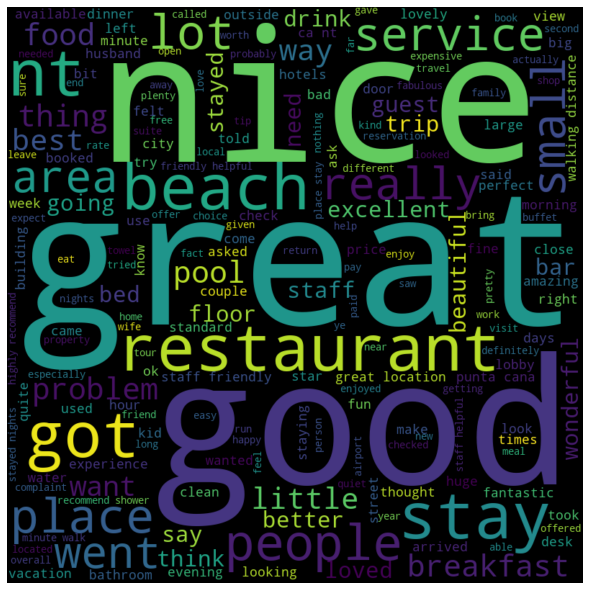

In [27]:
wordCloud_generator(non_tokenized) 

Vemos que, ahora, resaltan palabras como: "good, nice y great". Estas sí brindan más información del contexto, pero también indican (como habíamos visto previamente) que hay un desbalance de clases. El hecho de que resalten palabras positivas está asociado a calificaciones más altas por parte de los usuarios. Para ello, se hace necesario el balanceo de clases. Con esto, finalizamos la etapa de limpieza y eliminación de palabras no informativas.

---

### 2.2 Normalización: Stemming y Lematización
En esta parte del preprocesamiento, hacemos una eliminación de prefijos y sufijos, así como una lematización de los verbos. En el caso del Stemming, hay varios algoritmos que podemos utilizar: Porter, Snowball (Porter2) o Lancaster (Paice-Husk). De acuerdo a lo que investigamos, <a href='https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg'>la agresividad en el corte de raíces de las palabras de estos algoritmos aumenta, siendo Porter el menos agresivo y Lancaster el más agresivo </a>. En este sentido, parece ser que Lancaster (a pesar de ser el más eficiente de todos), puede crear muchas ambigüedades. Asimismo, Porter2 es un poco más agresivo que Porter, sin perder mucho el origen de las palabras y con un tiempo de cómputo razonable. El mismo Porter, creador del algoritmo, argumenta que es una mejora de su algoritmo original. Con el fin de tener la menor cantidad de palabras ambiguas, en un tiempo de cómputo razonable, decidimos usar Porter2. En el caso de la lematización, sí usamos <code>WordNetLemmatizer()</code> al ser el más usado en el mundo del procesamiento de textos.

In [28]:
def stem_words(words):
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

def join_stem_and_lemmatize(tokenized):
    return tokenized.apply(lambda x: ' '.join(map(str, x)))

tokenized = tokenized.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
non_tokenized = join_stem_and_lemmatize(tokenized)
# Vemos el inicio de nuestro nuevo conjunto 
tokenized.sample(5)

1186     [nt, hesit, recommend, friend, famili, read, f...
3842     [nice, husband, stay, riu, taino, week, novemb...
15322    [great, locat, stay, stopov, australia, yr, ol...
5824     [fantast, girlfriend, stay, sofitel, new, year...
9918     [excel, staff, odd, shower, good, point, outwe...
Name: Review, dtype: object

Veamos cómo nos quedó la nube de palabras después de esta tokenización,

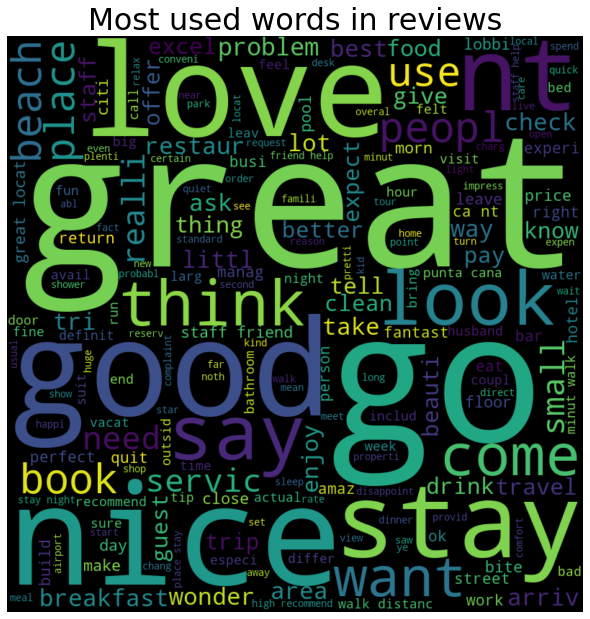

In [29]:
wordCloud_generator(non_tokenized, title="Most used words in reviews")

### 2.3 Generación de vectores
TODO: Aquí justificamos la elección de TF-IDF con el paper que encontramos y, además, con el libro del curso. 
TODO: TF-iDF (los vectorizadores, en general) reciben varios hiperparámetros. Uno de ellos, es el tamaño de los n-gramas. La determinación del tamaño de los n-gramas lo dejamos como un hiperparámetro para ajustar más adelante. En principio, permitiremos n-gramas de 1-3 palabras de longitud. 
*SUPER IMPORTANTE AQUÍ DECIR QUE ANTES HABÍAMOS DIVIDIDO EN TOKENS INIDIVIDUALES (SOLO PALABRAS Y NO BIGRAMAS O TRIGRAMAS) PARA PODER HACER EL PREPROCESAMIENTO Y ELIMINIACIÓN DE INFORMACIÓN. PERO LOS VECTORES SÍ DEPENDE DE LO QUE SEA MEJOR PARA EL ALGORITMO.*

In [30]:
def vectorize(non_tokenized, ini=1, fini=1):
    tf_idf = TfidfVectorizer(ngram_range=(ini, fini))
    X_tf_idf = tf_idf.fit_transform(non_tokenized)
    return tf_idf, X_tf_idf

Según lo propuesto para este ejercicio, debemos realizar, por un lado, reducción de dimensionalidad y, por otro lado, balanceo de clases. 

Empecemos por definir la reducción de dimensionalidad.

### 2.4 Reducción de dimensionalidad
*AQUÍ JUSTIFICAR POR QUÉ CHI^2 Y NO PCA: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 HABLAR DE SIGNIFICANCIA ESTADÍSTICA*
*Aquí hablamos de que el p-value limit es un hiperparámetro. 

In [31]:
def dimensionality_reduction(tf_idf, X_tf_idf, Y_train, non_tokenized, limit=0.95):
    X_names = tf_idf.get_feature_names()
    p_value_limit = limit #Hiperparametro 
    dtf_features = pd.DataFrame()
    for cat in np.unique(Y_train):
        chi2, p = feature_selection.chi2(X_tf_idf, Y_train==cat)
        dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
        dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    X_names = dtf_features["feature"].unique().tolist()
    # Podemos visualizar las 10 features elegidas más importantes por categoría
    for cat in np.unique(Y_train):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ",".join(
    dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")
    # Finalmente, pasamos las features más relevantes a TF-IDF 
    tf_idf = TfidfVectorizer(vocabulary=X_names)
    X_tf_idf = tf_idf.fit_transform(non_tokenized)
    return X_tf_idf

In [32]:
tf_idf, X_tf_idf = vectorize(non_tokenized)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, non_tokenized, limit=0.95)

# 1:
  . selected features: 657
  . top features: dirti,horribl,rude,terribl,worst,disgust,dump,filthi,tell,manag
# 2:
  . selected features: 328
  . top features: tell,poor,great,disappoint,rude,ok,terribl,smell,excel,okay
# 3:
  . selected features: 107
  . top features: ok,averag,okay,love,bad,basic,wonder,fantast,decent,noth
# 4:
  . selected features: 45
  . top features: good,nice,valu,pretti,clean,dirti,locat,worst,great,terribl
# 5:
  . selected features: 317
  . top features: fantast,wonder,excel,perfect,love,ok,dirti,bad,tell,worst
 


*AQUÍ COMENTAR ALGO SOBRE LA RELEVANCIA DE LOS FEATURES ELEGIDOS Y DE LOGRAMOS REDUCIR LA DIMENSIONALIDAD A 3094 FEATURES.*

In [33]:
X_tf_idf_dim_red.shape

(16392, 1101)

### 2.5 Oversampling con SMOTE para balanceo de clases
*LO HACEMOS SOBRE LA MATRIZ QUE SALE DE TF-IDF*

In [34]:
def balanceo_de_clases(X_tf_idf, Y_train):
    oversample = SMOTE(random_state=48)
    X_smote, Y_smote = oversample.fit_resample(X_tf_idf, Y_train)
    return X_smote, Y_smote

In [35]:
X_smote, Y_smote = balanceo_de_clases(X_tf_idf_dim_red, Y_train)

*REVISAMOS QUE HAYAN QUEDADO BALANCEADAS*

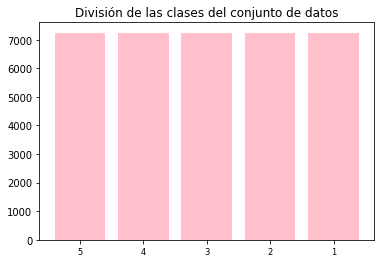

In [36]:
val_counts_y = Y_smote.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='pink')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

*VEMOS AQUÍ QUE YA ESTÁ TODO BALANCEADO*

*AQUÍ HACEMOS LOS COMENTARIOS FINALES: DECIMOS QUE YA ESTÁ LISTO PARA MODELADO. NO CONSTRUIMOS LAS PIPES AÚN PORQUE COMO SON PARA DIFERENTES MODELOS, ES MEJOR HACER UNA PARA CADA CASO.*

## 3. Modelado

In [37]:
# Primero, hacemos TODO el preproc hasta stem y lemmatize. Esto es igual para todos los algoritmos.
tokenized, non_tokenized = preprocessing(X_train)
tokenized = tokenized.apply(stem_and_lemmatize)
X_train = join_stem_and_lemmatize(tokenized)

## 3.1 SVM
Hablar un poco de SVM

---
### 3.1.1 Original
Aquí no hay ni balanceo ni reducción de dimensionalidad. Construimos la pipeline únicamente hasta TF-IDF. Nos preocupamos únicamente por elegir la cantidad de n-gramas que dan el mejor rendimiento. Nos quedamos con el resto de valores por defecto de SVC() debido a que el poder de cómputo es limitado (lo dejamos corriendo muchas horas y seguía sin dar resultados).
*SON UNIGRAMAS POR EL QUE CORRIMOS*

In [81]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', SVC(C=0.5))]
pipe = Pipeline(estimators)
SVM_original = pipe.fit(X_train, Y_train)

In [93]:
dump(SVM_original, 'svm_original.joblib') 
svm_model_original = load('svm_original.joblib') 

y_pred_SVM_original = svm_model_original.predict(X_train)
report_SVM_original = classification_report(Y_train, y_pred_SVM_original)
print("Test Report for original SVM\n", report_SVM_original)
print("Confusion Matrix for original SVM\n", confusion_matrix(Y_train, y_pred_SVM_original))

Test Report for original SVM
               precision    recall  f1-score   support

           1       0.99      0.82      0.90      1137
           2       0.85      0.80      0.82      1434
           3       0.97      0.24      0.38      1747
           4       0.71      0.76      0.73      4831
           5       0.82      0.96      0.88      7243

    accuracy                           0.80     16392
   macro avg       0.87      0.72      0.74     16392
weighted avg       0.82      0.80      0.78     16392

Confusion Matrix for original SVM
 [[ 937  120    3   44   33]
 [   5 1141   11  193   84]
 [   8   72  418  967  282]
 [   0   11    0 3660 1160]
 [   1    3    1  273 6965]]


### 3.1.2 Con reducción de dimensionalidad
Aquí usamos la función de Chi-cuadrado para la reducción de dimensionalidad, y dejamos los n_gramas obtenidos con el caso original. Entonces,

In [85]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, X_train, limit=0.95)

# 1:
  . selected features: 643
  . top features: dirti,horribl,rude,terribl,worst,disgust,dump,filthi,tell,manag
# 2:
  . selected features: 328
  . top features: tell,poor,great,disappoint,rude,ok,terribl,smell,excel,okay
# 3:
  . selected features: 108
  . top features: ok,averag,okay,love,bad,basic,wonder,fantast,decent,noth
# 4:
  . selected features: 46
  . top features: good,nice,valu,pretti,dirti,clean,locat,worst,great,terribl
# 5:
  . selected features: 319
  . top features: fantast,wonder,excel,perfect,love,ok,dirti,bad,tell,worst
 


RBF == accuracy al lineal https://stats.stackexchange.com/questions/155596/how-to-prove-that-text-is-linearly-separable

In [90]:
estimators = [('clf',SVC(gamma='scale'))]

pipe_dim_reduction = Pipeline(estimators)

param_grid = dict(clf__C = [0.01, 0.1, 1],
                  clf__kernel = ['poly', 'rbf'],
                 )

grid_search_svm_dim_red = GridSearchCV(pipe_dim_reduction, param_grid=param_grid,cv=2,verbose=3,scoring='f1_samples')
grid_search_svm_dim_red.fit(X_tf_idf_dim_red,Y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END .....clf__C=0.01, clf__kernel=poly;, score=0.442 total time=  29.4s
[CV 2/2] END .....clf__C=0.01, clf__kernel=poly;, score=0.442 total time=  28.8s
[CV 1/2] END ......clf__C=0.01, clf__kernel=rbf;, score=0.442 total time=  25.8s
[CV 2/2] END ......clf__C=0.01, clf__kernel=rbf;, score=0.442 total time=  25.7s
[CV 1/2] END ......clf__C=0.1, clf__kernel=poly;, score=0.443 total time=  29.4s
[CV 2/2] END ......clf__C=0.1, clf__kernel=poly;, score=0.442 total time=  29.9s
[CV 1/2] END .......clf__C=0.1, clf__kernel=rbf;, score=0.499 total time=  24.7s
[CV 2/2] END .......clf__C=0.1, clf__kernel=rbf;, score=0.496 total time=  24.9s
[CV 1/2] END ........clf__C=1, clf__kernel=poly;, score=0.575 total time=  31.8s
[CV 2/2] END ........clf__C=1, clf__kernel=poly;, score=0.584 total time=  33.4s
[CV 1/2] END .........clf__C=1, clf__kernel=rbf;, score=0.614 total time=  25.1s
[CV 2/2] END .........clf__C=1, clf__kernel=rbf;,

GridSearchCV(cv=2, estimator=Pipeline(steps=[('clf', SVC())]),
             param_grid={'clf__C': [0.01, 0.1, 1],
                         'clf__kernel': ['poly', 'rbf']},
             verbose=3)

In [91]:
print(grid_search_svm_dim_red.best_params_)

{'clf__C': 1, 'clf__kernel': 'rbf'}


In [92]:
dump(grid_search_svm_dim_red.best_estimator_, 'svm_dim_red.joblib') 
svm_model_dim_red = load('svm_dim_red.joblib') 

y_pred_SVM_dim_red = svm_model_dim_red.predict(X_tf_idf_dim_red)

Test Report for SVM with dim reduction
               precision    recall  f1-score   support

           1       0.99      0.82      0.90      1137
           2       0.85      0.80      0.82      1434
           3       0.97      0.24      0.38      1747
           4       0.71      0.76      0.73      4831
           5       0.82      0.96      0.88      7243

    accuracy                           0.80     16392
   macro avg       0.87      0.72      0.74     16392
weighted avg       0.82      0.80      0.78     16392

Confusion Matrix for SVM with dim reductio
 [[1046   66   12    8    5]
 [  37 1254   43   77   23]
 [  23   58 1202  367   97]
 [   6   31   17 3847  930]
 [   5   15   17  456 6750]]


In [94]:
report_SVM_dim_red = classification_report(Y_train, y_pred_SVM_dim_red)
print("Test Report for SVM with dim reduction\n", report_SVM_dim_red)
print("Confusion Matrix for SVM with dim reduction\n", confusion_matrix(Y_train, y_pred_SVM_dim_red))

Test Report for SVM with dim reduction
               precision    recall  f1-score   support

           1       0.94      0.92      0.93      1137
           2       0.88      0.87      0.88      1434
           3       0.93      0.69      0.79      1747
           4       0.81      0.80      0.80      4831
           5       0.86      0.93      0.90      7243

    accuracy                           0.86     16392
   macro avg       0.88      0.84      0.86     16392
weighted avg       0.86      0.86      0.86     16392

Confusion Matrix for SVM with dim reduction
 [[1046   66   12    8    5]
 [  37 1254   43   77   23]
 [  23   58 1202  367   97]
 [   6   31   17 3847  930]
 [   5   15   17  456 6750]]


### 3.1.3 Con SMOTE y reducción de dimensionalidad
Escribir: TODO

In [95]:
X_smote, Y_smote = balanceo_de_clases(X_tf_idf_dim_red, Y_train)

In [ ]:
estimators = [('clf',SVC(gamma='scale'))]

pipe_svm_SMOTE = Pipeline(estimators)

param_grid = dict(clf__C = [0.01, 0.1, 1],
                  clf__kernel = ['poly', 'rbf'],
                 )

grid_search_svm_SMOTE = GridSearchCV(pipe_svm_SMOTE, param_grid=param_grid,cv=2,verbose=3,scoring='f1_samples')
grid_search_svm_SMOTE.fit(X_smote, Y_smote)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [ ]:
print(grid_search_svm_SMOTE.best_params_)

In [ ]:
dump(grid_search_svm_SMOTE.best_estimator_, 'svm_SMOTE.joblib') 
svm_model_SMOTE = load('svm_SMOTE.joblib') 

y_pred_SVM_SMOTE = svm_model_SMOTE.predict(X_smote)
report_SVM_SMOTE = classification_report(Y_smote, y_pred_SVM_SMOTE)
print("Test Report for SVM with dim reduction and SMOTE\n", report_SVM_SMOTE)
print("Confusion Matrix for SVM with dim reduction and SMOTE\n", confusion_matrix(Y_smote, y_pred_SVM_SMOTE))

## 3.2 Naïve-Bayes
Hablar un poco de Naïve-Bayes para clasificación de texto

---
### 3.2.1 Original
Aquí no hay ni balanceo ni reducción de dimensionalidad. Construimos la pipeline únicamente hasta TF-IDF. Nos preocupamos únicamente por elegir la cantidad de n-gramas que dan el mejor rendimiento. Nos quedamos con el resto de valores por defecto de SVC() debido a que el poder de cómputo es limitado (lo dejamos corriendo muchas horas y seguía sin dar resultados).

In [112]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MultinomialNB())]
pipe_NB_original = Pipeline(estimators)

param_grid = dict(
                transform__ngram_range = [(1,1),(1,2),(1,3)],
                clf__alpha = [0.05, 0.1, 1]
                 )
grid_search_NB_original = GridSearchCV(pipe_NB_original, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_original.fit(X_train, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END clf__alpha=0.05, transform__ngram_range=(1, 1);, score=0.539 total time=   1.1s
[CV 2/5] END clf__alpha=0.05, transform__ngram_range=(1, 1);, score=0.530 total time=   1.1s
[CV 3/5] END clf__alpha=0.05, transform__ngram_range=(1, 1);, score=0.536 total time=   1.0s
[CV 4/5] END clf__alpha=0.05, transform__ngram_range=(1, 1);, score=0.528 total time=   1.1s
[CV 5/5] END clf__alpha=0.05, transform__ngram_range=(1, 1);, score=0.529 total time=   1.1s
[CV 1/5] END clf__alpha=0.05, transform__ngram_range=(1, 2);, score=0.496 total time=   4.8s
[CV 2/5] END clf__alpha=0.05, transform__ngram_range=(1, 2);, score=0.499 total time=   4.8s
[CV 3/5] END clf__alpha=0.05, transform__ngram_range=(1, 2);, score=0.506 total time=   4.6s
[CV 4/5] END clf__alpha=0.05, transform__ngram_range=(1, 2);, score=0.504 total time=   4.6s
[CV 5/5] END clf__alpha=0.05, transform__ngram_range=(1, 2);, score=0.509 total time=   5.2s
[CV 1/5] E

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.05, 0.1, 1],
                         'transform__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [113]:
grid_search_NB_original.best_params_

{'clf__alpha': 0.05, 'transform__ngram_range': (1, 1)}

In [114]:
dump(grid_search_NB_original.best_estimator_, 'NB_original.joblib') 
NB_original_model = load('NB_original.joblib') 

y_pred_NB_original = NB_original_model.predict(X_train)
report_NB_original = classification_report(Y_train, y_pred_NB_original)
print("Test Report for Multinomial NB\n", report_NB_original)
print("Confusion Matrix for Multinomial NB\n", confusion_matrix(Y_train, y_pred_NB_original))

Test Report for Multinomial NB
               precision    recall  f1-score   support

           1       0.99      0.88      0.93      1137
           2       0.97      0.80      0.88      1434
           3       0.99      0.63      0.77      1747
           4       0.85      0.84      0.84      4831
           5       0.86      0.98      0.92      7243

    accuracy                           0.88     16392
   macro avg       0.93      0.83      0.87     16392
weighted avg       0.89      0.88      0.88     16392

Confusion Matrix for Multinomial NB
 [[ 998   24    2   71   42]
 [   4 1148    4  174  104]
 [   6    6 1099  364  272]
 [   0    4    0 4043  784]
 [   1    3    1  107 7131]]


### 3.2.2 Con reducción de dimensionalidad

In [147]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, X_train, limit=0.90)

estimators = [('clf',MultinomialNB())]
pipe_NB_dim_red = Pipeline(estimators)

param_grid = dict(
                clf__alpha = [0.05, 0.1, 1]
                 )
grid_search_NB_dim_red = GridSearchCV(pipe_NB_dim_red, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_dim_red.fit(X_tf_idf_dim_red,Y_train)

# 1:
  . selected features: 1516
  . top features: dirti,horribl,rude,terribl,worst,disgust,dump,filthi,tell,manag
# 2:
  . selected features: 905
  . top features: tell,poor,great,disappoint,rude,ok,terribl,smell,excel,okay
# 3:
  . selected features: 426
  . top features: ok,averag,okay,love,bad,basic,wonder,fantast,decent,noth
# 4:
  . selected features: 91
  . top features: good,nice,valu,pretti,dirti,clean,locat,worst,great,terribl
# 5:
  . selected features: 488
  . top features: fantast,wonder,excel,perfect,love,ok,dirti,bad,tell,worst
 
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................clf__alpha=0.05;, score=0.608 total time=   0.0s
[CV 2/5] END ...................clf__alpha=0.05;, score=0.600 total time=   0.0s
[CV 3/5] END ...................clf__alpha=0.05;, score=0.628 total time=   0.0s
[CV 4/5] END ...................clf__alpha=0.05;, score=0.615 total time=   0.0s
[CV 5/5] END ...................clf__alpha=0.05;, score=0.612 tot

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.05, 0.1, 1]}, verbose=3)

In [148]:
grid_search_NB_dim_red.best_params_

{'clf__alpha': 0.05}

In [149]:
dump(grid_search_NB_dim_red.best_estimator_, 'NB_dim_red.joblib') 
NB_model_dim_red = load('NB_dim_red.joblib') 

y_pred_NB_dim_red = NB_model_dim_red.predict(X_tf_idf_dim_red)
report_NB_dim_red = classification_report(Y_train, y_pred_NB_dim_red)
print("Test Report for Multinomial NB with dim red\n", report_NB_dim_red)
print("Confusion Matrix for Multinomial NB with dim red\n", confusion_matrix(Y_train, y_pred_NB_dim_red))

Test Report for Multinomial NB with dim red
               precision    recall  f1-score   support

           1       0.91      0.78      0.84      1137
           2       0.75      0.64      0.69      1434
           3       0.87      0.27      0.41      1747
           4       0.53      0.50      0.52      4831
           5       0.70      0.89      0.79      7243

    accuracy                           0.68     16392
   macro avg       0.75      0.61      0.65     16392
weighted avg       0.69      0.68      0.66     16392

Confusion Matrix for Multinomial NB with dim red
 [[ 886  140   13   73   25]
 [  54  914   45  339   82]
 [  20  102  463  905  257]
 [  10   52   10 2405 2354]
 [   6   10    3  775 6449]]


### 3.2.3 Con SMOTE
NO usamos dim red porque ese hace underfitting.

In [168]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_smote, Y_smote = balanceo_de_clases(X_tf_idf, Y_train)

estimators = [('clf',MultinomialNB())]
pipe_NB_SMOTE = Pipeline(estimators)

param_grid = dict(
                clf__alpha = [0.05,0.1,1]
                 )
grid_search_NB_SMOTE = GridSearchCV(pipe_NB_SMOTE, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_SMOTE.fit(X_smote,Y_smote)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................clf__alpha=0.05;, score=0.832 total time=   0.0s
[CV 2/5] END ...................clf__alpha=0.05;, score=0.841 total time=   0.0s
[CV 3/5] END ...................clf__alpha=0.05;, score=0.857 total time=   0.0s
[CV 4/5] END ...................clf__alpha=0.05;, score=0.882 total time=   0.0s
[CV 5/5] END ...................clf__alpha=0.05;, score=0.906 total time=   0.1s
[CV 1/5] END ....................clf__alpha=0.1;, score=0.821 total time=   0.1s
[CV 2/5] END ....................clf__alpha=0.1;, score=0.830 total time=   0.1s
[CV 3/5] END ....................clf__alpha=0.1;, score=0.849 total time=   0.1s
[CV 4/5] END ....................clf__alpha=0.1;, score=0.874 total time=   0.1s
[CV 5/5] END ....................clf__alpha=0.1;, score=0.897 total time=   0.1s
[CV 1/5] END ......................clf__alpha=1;, score=0.722 total time=   0.1s
[CV 2/5] END ......................clf__alpha=1;,

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.05, 0.1, 1]}, verbose=3)

In [169]:
grid_search_NB_SMOTE.best_params_

{'clf__alpha': 0.05}

In [170]:
dump(grid_search_NB_SMOTE.best_estimator_, 'NB_SMOTE.joblib') 
NB_model_SMOTE = load('NB_SMOTE.joblib') 

y_pred_NB_SMOTE = NB_model_SMOTE.predict(X_smote)
report_NB_dim_red = classification_report(Y_smote, y_pred_NB_SMOTE)
print("Test Report for Multinomial NB with SMOTE\n", report_NB_dim_red)
print("Confusion Matrix for Multinomial NB with SMOTE\n", confusion_matrix(Y_smote, y_pred_NB_SMOTE))

Test Report for Multinomial NB with SMOTE
               precision    recall  f1-score   support

           1       0.98      1.00      0.99      7243
           2       0.97      0.98      0.98      7243
           3       0.96      0.97      0.97      7243
           4       0.92      0.91      0.92      7243
           5       0.93      0.91      0.92      7243

    accuracy                           0.95     36215
   macro avg       0.95      0.95      0.95     36215
weighted avg       0.95      0.95      0.95     36215

Confusion Matrix for Multinomial NB with SMOTE
 [[7214   20    1    7    1]
 [  39 7132   52    9   11]
 [  39   60 7010   86   48]
 [  20   92  116 6607  408]
 [  15   75  102  455 6596]]


### 3.2.4 Usando ComplementNB()
NO usamos dim red porque ese hace underfitting.

In [172]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', ComplementNB())]
pipe_NB_complement = Pipeline(estimators)

param_grid = dict(
                transform__ngram_range = [(1,1),(1,2)],
                clf__alpha = [0.05, 0.1, 1],
                 )
grid_search_NB_complement = GridSearchCV(pipe_NB_complement, param_grid=param_grid,cv=5,verbose=3,scoring='f1_samples')
grid_search_NB_complement.fit(X_train, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 1);, score=0.520 total time=   1.1s
[CV 2/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 1);, score=0.512 total time=   1.0s
[CV 3/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 1);, score=0.498 total time=   1.0s
[CV 4/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 1);, score=0.517 total time=   1.0s
[CV 5/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 1);, score=0.505 total time=   1.0s
[CV 1/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 2);, score=0.547 total time=   4.6s
[CV 2/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 2);, score=0.548 total time=   4.8s
[CV 3/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_range=(1, 2);, score=0.554 total time=   4.5s
[CV 4/5] END clf__alpha=0.05, clf__norm=True, transform__ngram_rang

[CV 2/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 1);, score=0.489 total time=   1.0s
[CV 3/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 1);, score=0.487 total time=   1.0s
[CV 4/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 1);, score=0.486 total time=   1.0s
[CV 5/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 1);, score=0.491 total time=   1.0s
[CV 1/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 2);, score=0.445 total time=   4.3s
[CV 2/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 2);, score=0.449 total time=   4.4s
[CV 3/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 2);, score=0.446 total time=   4.3s
[CV 4/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 2);, score=0.445 total time=   4.3s
[CV 5/5] END clf__alpha=1, clf__norm=False, transform__ngram_range=(1, 2);, score=0.448 total time=   4.3s
[CV 1/5] END clf__alpha=1, clf__norm=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             param_grid={'clf__alpha': [0.05, 0.1, 1],
                         'clf__norm': [True, False],
                         'transform__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=3)

In [173]:
grid_search_NB_complement.best_params_

{'clf__alpha': 0.05, 'clf__norm': False, 'transform__ngram_range': (1, 2)}

In [174]:
dump(grid_search_NB_complement.best_estimator_, 'NB_Complement.joblib') 
NB_model_complement = load('NB_Complement.joblib') 

y_pred_NB_complement = NB_model_complement.predict(X_train)
report_NB_complement = classification_report(Y_train, y_pred_NB_complement)
print("Test Report for Complement NB \n", report_NB_complement)
print("Confusion Matrix for Complement NB\n", confusion_matrix(Y_train, y_pred_NB_complement))

Test Report for Complement NB 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      1137
           2       1.00      1.00      1.00      1434
           3       1.00      1.00      1.00      1747
           4       1.00      1.00      1.00      4831
           5       1.00      1.00      1.00      7243

    accuracy                           1.00     16392
   macro avg       1.00      1.00      1.00     16392
weighted avg       1.00      1.00      1.00     16392

Confusion Matrix for Complement NB
 [[1137    0    0    0    0]
 [   0 1434    0    0    0]
 [   0    0 1747    0    0]
 [   0    0    0 4827    4]
 [   0    0    0    0 7243]]


<b>ESCRIBIR LO DEL OVERFITTING</b>
ELEGIMOS MAYOR REGULARIZACION

In [181]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', ComplementNB())]
pipe_NB_complement = Pipeline(estimators)

param_grid = dict(
                transform__ngram_range = [(1,1),(1,2),(1,3)],
                # IMPORTANTE: REVISAR CON 0.1 O 0.5 DEPSUES DE VER TEST
                clf__alpha = [0.1, 0.5, 1],
                 )
grid_search_NB_complement = GridSearchCV(pipe_NB_complement, param_grid=param_grid,cv=5,verbose=3)
grid_search_NB_complement.fit(X_train, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END clf__alpha=0.1, transform__ngram_range=(1, 1);, score=0.557 total time=   1.2s
[CV 2/5] END clf__alpha=0.1, transform__ngram_range=(1, 1);, score=0.551 total time=   1.1s
[CV 3/5] END clf__alpha=0.1, transform__ngram_range=(1, 1);, score=0.540 total time=   1.2s
[CV 4/5] END clf__alpha=0.1, transform__ngram_range=(1, 1);, score=0.547 total time=   1.0s
[CV 5/5] END clf__alpha=0.1, transform__ngram_range=(1, 1);, score=0.548 total time=   1.0s
[CV 1/5] END clf__alpha=0.1, transform__ngram_range=(1, 2);, score=0.540 total time=   4.7s
[CV 2/5] END clf__alpha=0.1, transform__ngram_range=(1, 2);, score=0.541 total time=   4.8s
[CV 3/5] END clf__alpha=0.1, transform__ngram_range=(1, 2);, score=0.544 total time=   4.5s
[CV 4/5] END clf__alpha=0.1, transform__ngram_range=(1, 2);, score=0.547 total time=   4.3s
[CV 5/5] END clf__alpha=0.1, transform__ngram_range=(1, 2);, score=0.555 total time=   4.4s
[CV 1/5] END clf__al

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             param_grid={'clf__alpha': [0.1, 0.5, 1],
                         'transform__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [182]:
grid_search_NB_complement.best_params_

{'clf__alpha': 0.1, 'transform__ngram_range': (1, 1)}

In [183]:
dump(grid_search_NB_complement.best_estimator_, 'NB_Complement.joblib') 
NB_model_complement = load('NB_Complement.joblib') 

y_pred_NB_complement = NB_model_complement.predict(X_train)
report_NB_complement = classification_report(Y_train, y_pred_NB_complement)
print("Test Report for Complement NB \n", report_NB_complement)
print("Confusion Matrix for Complement NB\n", confusion_matrix(Y_train, y_pred_NB_complement))

Test Report for Complement NB 
               precision    recall  f1-score   support

           1       0.89      0.99      0.94      1137
           2       0.95      0.95      0.95      1434
           3       0.98      0.86      0.91      1747
           4       0.93      0.83      0.88      4831
           5       0.89      0.97      0.93      7243

    accuracy                           0.92     16392
   macro avg       0.93      0.92      0.92     16392
weighted avg       0.92      0.92      0.92     16392

Confusion Matrix for Complement NB
 [[1127    6    0    2    2]
 [  39 1366    6   14    9]
 [  31   18 1495  126   77]
 [  33   27   12 4019  740]
 [  32   25   12  144 7030]]


## 3.3 MLP
Hablar de MLP
### 3.3.1 Original

In [235]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MLPClassifier(verbose=True))]
pipe_MLP_original = Pipeline(estimators)

pipe = Pipeline(estimators)
MLP_original = pipe.fit(X_train, Y_train)

Iteration 1, loss = 1.30973589
Iteration 2, loss = 0.95928705
Iteration 3, loss = 0.70669205
Iteration 4, loss = 0.52460791
Iteration 5, loss = 0.38428044
Iteration 6, loss = 0.27968167
Iteration 7, loss = 0.20522466
Iteration 8, loss = 0.15319248
Iteration 9, loss = 0.11732657
Iteration 10, loss = 0.09130524
Iteration 11, loss = 0.07271258
Iteration 12, loss = 0.05889883
Iteration 13, loss = 0.04882509
Iteration 14, loss = 0.04085338
Iteration 15, loss = 0.03475295
Iteration 16, loss = 0.03007445
Iteration 17, loss = 0.02634831
Iteration 18, loss = 0.02327999
Iteration 19, loss = 0.02083944
Iteration 20, loss = 0.01886844
Iteration 21, loss = 0.01722284
Iteration 22, loss = 0.01582811
Iteration 23, loss = 0.01469415
Iteration 24, loss = 0.01370497
Iteration 25, loss = 0.01287604
Iteration 26, loss = 0.01215869
Iteration 27, loss = 0.01154441
Iteration 28, loss = 0.01099143
Iteration 29, loss = 0.01050368
Iteration 30, loss = 0.01008257
Iteration 31, loss = 0.00970811
Iteration 32, los

In [236]:
dump(MLP_original, 'MLP_original.joblib') 
MLP_model_original = load('MLP_original.joblib') 

y_pred_MLP_original = MLP_model_original.predict(X_train)
report_MLP_original = classification_report(Y_train, y_pred_MLP_original)
print("Test Report for original MLP\n", report_MLP_original)
print("Confusion Matrix for original MLP\n", confusion_matrix(Y_train, y_pred_MLP_original))

Test Report for original MLP
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      1137
           2       1.00      1.00      1.00      1434
           3       1.00      1.00      1.00      1747
           4       1.00      1.00      1.00      4831
           5       1.00      1.00      1.00      7243

    accuracy                           1.00     16392
   macro avg       1.00      1.00      1.00     16392
weighted avg       1.00      1.00      1.00     16392

Confusion Matrix for original MLP
 [[1137    0    0    0    0]
 [   0 1434    0    0    0]
 [   0    0 1747    0    0]
 [   0    0    0 4831    0]
 [   0    0    0    0 7243]]


Vemos que está haciendo overfitting. Haciendo varias pruebas, nos dimos cuenta de que es mejor tener pocas neuronas y bastante regularización. Ajustamos los hiperparámetros de acuerdo a nuestras observaciones (una de las observaciones la presentamos en la celda a continuación).

In [237]:
estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_original = Pipeline(estimators)

pipe = Pipeline(estimators)
MLP_original = pipe.fit(X_train, Y_train)

/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [238]:
dump(MLP_original, 'MLP_original.joblib') 
MLP_model_original = load('MLP_original.joblib') 

y_pred_MLP_original = MLP_model_original.predict(X_train)
report_MLP_original = classification_report(Y_train, y_pred_MLP_original)
print("Test Report for original MLP\n", report_MLP_original)
print("Confusion Matrix for original MLP\n", confusion_matrix(Y_train, y_pred_MLP_original))

Test Report for original MLP
               precision    recall  f1-score   support

           1       0.85      0.82      0.83      1137
           2       0.78      0.68      0.73      1434
           3       0.87      0.74      0.80      1747
           4       0.86      0.89      0.87      4831
           5       0.92      0.96      0.94      7243

    accuracy                           0.88     16392
   macro avg       0.86      0.82      0.84     16392
weighted avg       0.88      0.88      0.88     16392

Confusion Matrix for original MLP
 [[ 928  178    9    3   19]
 [ 145  975  144  140   30]
 [  14   60 1290  300   83]
 [   0   29   32 4291  479]
 [   1    2    2  263 6975]]


Ahora, sí hacemos el tuning de hiperparámetros.

In [54]:
def multiple_f1(y_true,y_pred,average='samples'):
    yt =  np.argmax(y_true, axis=1)
    yp =  np.argmax(y_pred, axis=1)
    return f1_score(yt,yp,average=average,zero_division=0)

new_score = make_scorer(multiple_f1, average='samples')

estimators = [('transform', TfidfVectorizer(ngram_range=(1, 1))),
             ('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_original = Pipeline(estimators)

param_grid = dict(
                clf__hidden_layer_sizes = [3,4,5],
                clf__alpha = [0.1, 0.15, 0.25]
                 )
grid_search_MLP_original = GridSearchCV(pipe_MLP_original, param_grid=param_grid,cv=2,verbose=3, scoring='f1_weighted')
grid_search_MLP_original.fit(X_train, Y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=3;, score=0.556 total time=  13.5s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=3;, score=0.570 total time=  13.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=4;, score=0.560 total time=  15.8s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=4;, score=0.568 total time=  16.4s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=5;, score=0.563 total time=  20.2s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=5;, score=0.567 total time=  18.2s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.15, clf__hidden_layer_sizes=3;, score=0.572 total time=  14.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.15, clf__hidden_layer_sizes=3;, score=0.530 total time=  13.9s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.15, clf__hidden_layer_sizes=4;, score=0.564 total time=  15.7s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.15, clf__hidden_layer_sizes=4;, score=0.579 total time=  15.9s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.15, clf__hidden_layer_sizes=5;, score=0.568 total time=  18.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.15, clf__hidden_layer_sizes=5;, score=0.570 total time=  17.9s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.25, clf__hidden_layer_sizes=3;, score=0.586 total time=  13.8s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.25, clf__hidden_layer_sizes=3;, score=0.586 total time=  13.4s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.25, clf__hidden_layer_sizes=4;, score=0.578 total time=  15.5s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.25, clf__hidden_layer_sizes=4;, score=0.586 total time=  15.8s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.25, clf__hidden_layer_sizes=5;, score=0.593 total time=  18.9s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.25, clf__hidden_layer_sizes=5;, score=0.588 total time=  19.0s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('transform', TfidfVectorizer()),
                                       ('clf',
                                        MLPClassifier(alpha=0.25,
                                                      hidden_layer_sizes=5))]),
             param_grid={'clf__alpha': [0.1, 0.15, 0.25],
                         'clf__hidden_layer_sizes': [3, 4, 5]},
             scoring='f1_weighted', verbose=3)

In [55]:
grid_search_MLP_original.best_params_

{'clf__alpha': 0.25, 'clf__hidden_layer_sizes': 5}

In [56]:
dump(grid_search_MLP_original.best_estimator_, 'MLP_original.joblib') 
MLP_model_original = load('MLP_original.joblib') 

y_pred_MLP_original = MLP_model_original.predict(X_train)
report_MLP_original = classification_report(Y_train, y_pred_MLP_original)
print("Test Report for original MLP using CV\n", report_MLP_original)
print("Confusion Matrix for original MLP using CV\n", confusion_matrix(Y_train, y_pred_MLP_original))

Test Report for original MLP using CV
               precision    recall  f1-score   support

           1       0.84      0.85      0.84      1137
           2       0.73      0.63      0.67      1434
           3       0.82      0.69      0.75      1747
           4       0.87      0.88      0.87      4831
           5       0.91      0.96      0.94      7243

    accuracy                           0.87     16392
   macro avg       0.83      0.80      0.81     16392
weighted avg       0.87      0.87      0.87     16392

Confusion Matrix for original MLP using CV
 [[ 962  157    0    8   10]
 [ 179  898  219  110   28]
 [   6  151 1206  288   96]
 [   3   26   35 4234  533]
 [   2    1    5  252 6983]]


### 3.3.2 Con Feature Selection


Aquí aumentamos más la cantidad de neuronas y disminuímos los valores de alpha porque, al comienzo, parecía haciendo underfitting. No obstante, nos dimos cuenta de que esto en realidad se debe a la reducción en las features.

In [57]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_tf_idf_dim_red = dimensionality_reduction(tf_idf, X_tf_idf, Y_train, X_train, limit=0.90)

estimators = [('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_dim_red = Pipeline(estimators)

param_grid = dict(
                clf__hidden_layer_sizes = [5,10,20],
                clf__alpha = [0.01,0.1,0.25]
                 )
grid_search_MLP_dim_red = GridSearchCV(pipe_MLP_dim_red, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_MLP_dim_red.fit(X_tf_idf_dim_red,Y_train)

# 1:
  . selected features: 1526
  . top features: dirti,horribl,rude,terribl,worst,disgust,dump,filthi,tell,manag
# 2:
  . selected features: 903
  . top features: tell,poor,great,disappoint,rude,ok,terribl,smell,excel,okay
# 3:
  . selected features: 422
  . top features: ok,averag,okay,love,bad,basic,wonder,fantast,decent,noth
# 4:
  . selected features: 91
  . top features: good,nice,valu,pretti,clean,dirti,locat,worst,great,terribl
# 5:
  . selected features: 489
  . top features: fantast,wonder,excel,perfect,love,ok,dirti,bad,tell,worst
 
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.01, clf__hidden_layer_sizes=5;, score=0.588 total time=   6.6s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.01, clf__hidden_layer_sizes=5;, score=0.595 total time=   6.7s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.01, clf__hidden_layer_sizes=10;, score=0.579 total time=   8.2s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.01, clf__hidden_layer_sizes=10;, score=0.584 total time=   8.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.01, clf__hidden_layer_sizes=20;, score=0.575 total time=  10.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.01, clf__hidden_layer_sizes=20;, score=0.574 total time=   9.6s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=5;, score=0.600 total time=   6.6s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=5;, score=0.607 total time=   6.5s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=10;, score=0.592 total time=   8.6s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=10;, score=0.603 total time=   8.6s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=20;, score=0.595 total time=  10.4s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=20;, score=0.599 total time=  10.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.25, clf__hidden_layer_sizes=5;, score=0.603 total time=   7.3s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.25, clf__hidden_layer_sizes=5;, score=0.614 total time=   6.9s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.25, clf__hidden_layer_sizes=10;, score=0.600 total time=   8.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.25, clf__hidden_layer_sizes=10;, score=0.615 total time=   8.2s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.25, clf__hidden_layer_sizes=20;, score=0.599 total time=  10.7s
[CV 2/2] END clf__alpha=0.25, clf__hidden_layer_sizes=20;, score=0.615 total time=  10.1s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('clf',
                                        MLPClassifier(alpha=0.25,
                                                      hidden_layer_sizes=5))]),
             param_grid={'clf__alpha': [0.01, 0.1, 0.25],
                         'clf__hidden_layer_sizes': [5, 10, 20]},
             scoring='f1_weighted', verbose=3)

In [58]:
grid_search_MLP_dim_red.best_params_

{'clf__alpha': 0.25, 'clf__hidden_layer_sizes': 5}

In [59]:
dump(grid_search_MLP_dim_red.best_estimator_, 'MLP_dim_red.joblib') 
MLP_model_dim_red = load('MLP_dim_red.joblib') 

y_pred_MLP_dim_red = MLP_model_dim_red.predict(X_tf_idf_dim_red)
report_MLP_dim_red = classification_report(Y_train, y_pred_MLP_dim_red)
print("Test Report for MLP with dim red\n", report_MLP_dim_red)
print("Confusion Matrix for MLP MLP with dim red\n", confusion_matrix(Y_train, y_pred_MLP_dim_red))

Test Report for MLP with dim red
               precision    recall  f1-score   support

           1       0.79      0.81      0.80      1137
           2       0.64      0.65      0.64      1434
           3       0.63      0.38      0.47      1747
           4       0.58      0.57      0.58      4831
           5       0.76      0.83      0.79      7243

    accuracy                           0.69     16392
   macro avg       0.68      0.65      0.66     16392
weighted avg       0.68      0.69      0.68     16392

Confusion Matrix for MLP MLP with dim red
 [[ 917  182   12   15   11]
 [ 171  930  147  145   41]
 [  43  229  661  683  131]
 [  18   87  204 2760 1762]
 [  16   27   25 1150 6025]]


### 3.3.3 Con SMOTE

Vemos que la selección de features da un modelo con un puntaje f1 bastante menor al original. Por ello, al usar SMOTE, preferimos utilizar todas las features. Sin reducción de dimensionalidad.

In [ ]:
tf_idf, X_tf_idf = vectorize(X_train, ini=1, fini=1)
X_smote, Y_smote = balanceo_de_clases(X_tf_idf, Y_train)

estimators = [('clf', MLPClassifier(hidden_layer_sizes=5, alpha=0.25))]
pipe_MLP_SMOTE = Pipeline(estimators)

param_grid = dict(
                clf__hidden_layer_sizes = [3,4,5],
                clf__alpha = [0.1, 0.15, 0.25]
                 )
grid_search_MLP_SMOTE = GridSearchCV(pipe_MLP_SMOTE, param_grid=param_grid,cv=2,verbose=3,scoring='f1_weighted')
grid_search_MLP_SMOTE.fit(X_smote,Y_smote)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=3;, score=0.822 total time=  44.9s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=3;, score=0.876 total time=  44.0s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=4;, score=0.830 total time=  56.0s


/Users/sofiaalvarezlopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END clf__alpha=0.1, clf__hidden_layer_sizes=4;, score=0.884 total time=  51.2s
[CV 1/2] END clf__alpha=0.1, clf__hidden_layer_sizes=5;, score=0.833 total time= 1.0min


In [ ]:
grid_search_MLP_SMOTE.best_params_

In [ ]:
dump(grid_search_MLP_SMOTE.best_estimator_, 'MLP_SMOTE.joblib') 
MLP_model_SMOTE = load('MLP_SMOTE.joblib') 

y_pred_MLP_SMOTE = MLP_model_SMOTE.predict(X_smote)
report_MLP_SMOTE = classification_report(Y_smote, y_pred_MLP_SMOTE)
print("Test Report for MLP with SMOTE\n", report_MLP_dim_red)
print("Confusion Matrix for MLP with SMOTE\n", confusion_matrix(Y_smote, y_pred_MLP_SMOTE))

# TEST

In [197]:
# Primero, hacemos TODO el preproc hasta stem y lemmatize. Esto es igual para todos los algoritmos.
tokenized, non_tokenized = preprocessing(X_test)
tokenized = tokenized.apply(stem_and_lemmatize)
X_test = join_stem_and_lemmatize(tokenized)

In [213]:
Y_test_pred = MLP_model_original.predict(X_test)

In [214]:
print(classification_report(Y_test,Y_test_pred))

              precision    recall  f1-score   support

           1       0.71      0.64      0.68       284
           2       0.46      0.40      0.43       359
           3       0.48      0.33      0.39       437
           4       0.53      0.50      0.51      1208
           5       0.71      0.81      0.76      1811

    accuracy                           0.62      4099
   macro avg       0.58      0.54      0.55      4099
weighted avg       0.61      0.62      0.61      4099



<h2 id='bibliografia'>Bibliografía</h2>

---

<a id='geron'>[1]</a> Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299
